<a href="https://colab.research.google.com/github/Sasan-Tech/Automated-Social-Distance-Monitoring-System/blob/main/ASDTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Common Parts


Please run these cells first before you start to work with the program

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install tf_slim

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

In [ ]:
!apt-get update

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

In [ ]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [ ]:
!python object_detection/builders/model_builder_test.py

# References

*Proto?*

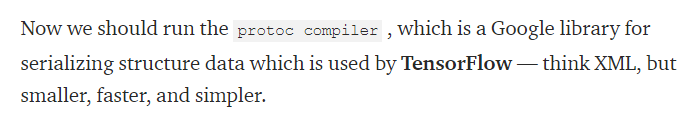

*what thing that is measured by mAP?*

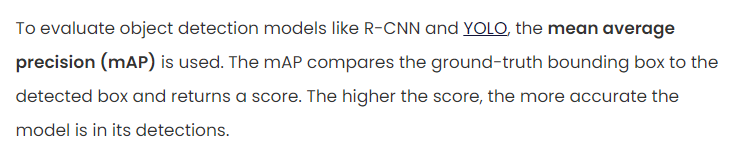

# Pre-processing


Prepare all the files that we need before we train and test the model

In [ ]:
factor = 2 #will be used in the extraction later on
!pwd

Make the train_val.txt

In [ ]:
f = open("/content/drive/My Drive/SocialDistancing/Config/train_val.txt",'w')
for i in range(3000):
    f.write(str(i) + '\n')
f.close()

Extract the frames from the video

In [ ]:
import os
from cv2 import cv2
import numpy as np

frame = 0

#Load the video
capture = cv2.VideoCapture("/content/drive/My Drive/SocialDistancing/Data/TownCentreXVID.mp4")

#Print number of frames
numberOfFrames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
#print('Number of frames: ', numberOfFrames)

#Iterate the video
while True:
    #Read per frame
    stillReading, image = capture.read()

    #If still in the range of the video
    if stillReading:
        #Take 80% of the total frames for training
        if frame < (numberOfFrames * 0.8):
            targetLoc = '/content/drive/My Drive/SocialDistancing/Extracted/Train'
        else:
            targetLoc = '/content/drive/My Drive/SocialDistancing/Extracted/Test'

        image = cv2.resize(image, (1920 // factor, 1080 // factor))

        #Put the frames in the allocated folder
        cv2.imwrite(os.path.join(targetLoc, str(frame) + ".jpg"), image)

        #Move to the next frame
        frame += 1
        print('Processed: ', frame, end = '\n')

    #The video has ended
    else:
        print("Done extracting")
        break

#Release the video
capture.release()

Create XML for the groundtruth

In [ ]:
import os
import numpy as np
import pandas as pd

#Load the data and specify auto indent according to specified x
gtData = pd.read_csv("/content/drive/MyDrive/SocialDistancing/Data/TownCentre-groundtruth.top", header=None)
indent = lambda x,y: ''.join([' ' for _ in range(y)]) + x

train_size = 3000
width, height = 1920 // factor, 1080 // factor
name = 'pedestrian'

#Iterate each frame
for frame_number in range(train_size):
  #Take the frame if the number in groundtruth data is the same with the current frame number
  frame = gtData.loc[gtData[1] == frame_number]

  #Specify the corners for the frames with the same number
  x1 = list(frame[8]) #Body Left
  y1 = list(frame[9]) #Body Top
  x2 = list(frame[10]) #Body Right
  y2 = list(frame[11]) #Body Bottom

  #Group the points
  corners = [[(round(x1zip), round(y1zip)), (round(x2zip), round(y2zip))] for x1zip, y1zip, x2zip, y2zip in zip(x1, y1, x2, y2)]

  #Write it into XML format
  with open(os.path.join("/content/drive/MyDrive/SocialDistancing/XMLs", str(frame_number) + '.xml'), 'w') as xmlFile:
      #Specify the frame size
      xmlFile.write('<annotation>\n')
      xmlFile.write(indent('<filename>' + str(frame_number) + '.jpg' + '</filename>\n', 1))
      xmlFile.write(indent('<size>\n', 1))
      xmlFile.write(indent('<width>' + str(width) + '</width>\n', 2))
      xmlFile.write(indent('<height>' + str(height) + '</height>\n', 2))
      xmlFile.write(indent('<depth>3</depth>\n', 2))
      xmlFile.write(indent('</size>\n',1))

      for point in corners:
          top_left = point[0] #x1 and y1
          bottom_right = point[1] #x2 and y2

          if top_left[0] > bottom_right[0]: #if x1 > x2
              xmax, xmin = top_left[0] // factor, bottom_right[0] // factor
          else:
              xmin, xmax = top_left[0] // factor, bottom_right[0] // factor

          if top_left[1] > bottom_right[1]: #if y1 > y2
              ymax, ymin = top_left[1] // factor, bottom_right[1] // factor
          else:
              ymin, ymax = top_left[1] // factor, bottom_right[1] // factor

          #Write the point position
          xmlFile.write(indent('<object>\n', 1))
          xmlFile.write(indent('<name>' + name + '</name>\n', 2))
          xmlFile.write(indent('<bndbox>\n', 2))
          xmlFile.write(indent('<xmin>' + str(xmin) + '</xmin>\n', 3))
          xmlFile.write(indent('<ymin>' + str(ymin) + '</ymin>\n', 3))
          xmlFile.write(indent('<xmax>' + str(xmax) + '</xmax>\n', 3))
          xmlFile.write(indent('<ymax>' + str(ymax) + '</ymax>\n', 3))
          xmlFile.write(indent('</bndbox>\n', 2))
          xmlFile.write(indent('</object>\n', 1))

      xmlFile.write('</annotation>\n')

  #Print the process
  print('File:', frame_number, end= '\n')

Prepare the files for TFRecord

*Specifying paths*

In [ ]:
import hashlib
import io
import os
import random
import logging
import re

from lxml import etree
import PIL.Image
import tensorflow as tf

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

label_map = label_map_util.get_label_map_dict('/content/drive/MyDrive/SocialDistancing/label_map.pbtxt')
image_directory = '/content/drive/MyDrive/SocialDistancing/Extracted/Train'
examples_list = dataset_util.read_examples_list('/content/drive/MyDrive/SocialDistancing/Config/train_val.txt')

num_examples = len(examples_list)
num_train = int(0.95 * num_examples)
train_examples = examples_list[:num_train]
val_examples = examples_list[num_train:]

train_output = '/content/drive/MyDrive/SocialDistancing/train.record'
validation_output = '/content/drive/MyDrive/SocialDistancing/test.record'

*Prepare the train.record*

In [ ]:
train_writer = tf.io.TFRecordWriter(train_output)

for index, example in enumerate(train_examples):
    path = os.path.join('/content/drive/MyDrive/SocialDistancing/XMLs', example + '.xml')

    with open(path, 'r') as fid:
        xml_string = fid.read()

    xml = etree.fromstring(xml_string)
    data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

    image_path = os.path.join(image_directory, data['filename'])
    with open(image_path, 'rb') as fid:
        encoded_image = fid.read()
    encoded_image_io = io.BytesIO(encoded_image)
    image = PIL.Image.open(encoded_image_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    key = hashlib.sha256(encoded_image).hexdigest()

    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    poses = []
    difficult_obj = []

    for obj in data['object']:
        difficult_obj.append(int(0))

        xmin.append(float(obj['bndbox']['xmin']) / width)
        ymin.append(float(obj['bndbox']['ymin']) / height)
        xmax.append(float(obj['bndbox']['xmax']) / width)
        ymax.append(float(obj['bndbox']['ymax']) / height)

        classes_text.append(obj['name'].encode('utf8'))
        classes.append(label_map[obj['name']])
        truncated.append(int(0))
        poses.append('Unspecified'.encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/difficult': dataset_util.int64_list_feature(difficult_obj),
        'image/object/truncated': dataset_util.int64_list_feature(truncated),
        'image/object/view': dataset_util.bytes_list_feature(poses)
    }))


    train_writer.write(example.SerializeToString())

train_writer.close()

*Prepare the test.record*

In [ ]:
validation_writer = tf.io.TFRecordWriter(validation_output)

for index, example in enumerate(val_examples):
    path = os.path.join('/content/drive/MyDrive/SocialDistancing/XMLs', example + '.xml')

    with open(path, 'r') as fid:
        xml_string = fid.read()

    xml = etree.fromstring(xml_string)
    data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

    image_path = os.path.join(image_directory, data['filename'])
    with open(image_path, 'rb') as fid:
        encoded_image = fid.read()
    encoded_image_io = io.BytesIO(encoded_image)
    image = PIL.Image.open(encoded_image_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    key = hashlib.sha256(encoded_image).hexdigest()

    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    poses = []
    difficult_obj = []

    for obj in data['object']:
        difficult_obj.append(int(0))

        xmin.append(float(obj['bndbox']['xmin']) / width)
        ymin.append(float(obj['bndbox']['ymin']) / height)
        xmax.append(float(obj['bndbox']['xmax']) / width)
        ymax.append(float(obj['bndbox']['ymax']) / height)

        classes_text.append(obj['name'].encode('utf8'))
        classes.append(label_map[obj['name']])
        truncated.append(int(0))
        poses.append('Unspecified'.encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image),
        'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/difficult': dataset_util.int64_list_feature(difficult_obj),
        'image/object/truncated': dataset_util.int64_list_feature(truncated),
        'image/object/view': dataset_util.bytes_list_feature(poses)
    }))


    validation_writer.write(example.SerializeToString())

validation_writer.close()

#Train model

In [ ]:
pip install lvis

In [ ]:
!python /content/models/research/object_detection/model_main.py \
      --logtostderr \
      --model_dir="/content/drive/MyDrive/SocialDistancing/Models/trained/rfcn_trained/" \
      --pipeline_config_path='/content/drive/MyDrive/SocialDistancing/Models/pre-trained/rfcn_resnet101_coco_2018_01_28/pipeline.config'

Note:

Please change the model_dir according to the model that you want to train, so do the pipeline.config

You can also change the parameter inside of the pipeline.config to accomodate your needs


# Export

This process will give us the model that we will use for prediction later on

Please change the path accordingly

In [ ]:
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path="/content/drive/MyDrive/SocialDistancing/Models/pre-trained/ssd_mobilenet_v1_coco_2018_01_28/pipeline.config" \
    --output_directory="/content/drive/MyDrive/SocialDistancing/Models/exported/ssd_mobilenet_v1_coco_exported" \
    --trained_checkpoint_prefix="/content/drive/MyDrive/SocialDistancing/Models/trained/ssd_mobilenet_v1_coco_trained/model.ckpt-49768"

# Test Images


Produce the prediction outputs

In [ ]:
import numpy as np
import six.moves.urllib as urllib
import glob
import itertools
import zipfile
import matplotlib
import math
import random
import cv2

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from object_detection.utils import ops as utils_ops
from google.colab.patches import cv2_imshow
from matplotlib.colors import colorConverter


%matplotlib inline

### **References**

*What is Graph and GraphDef?*

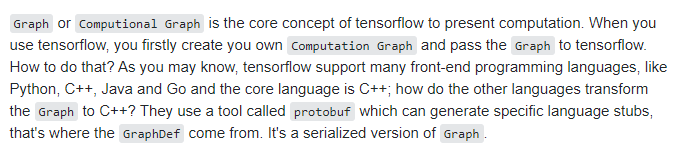

*What tf.squeeze did?*

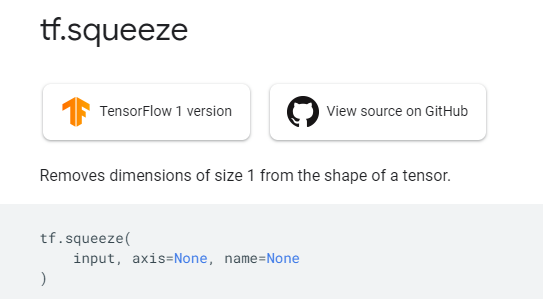

*3D Reshape?*

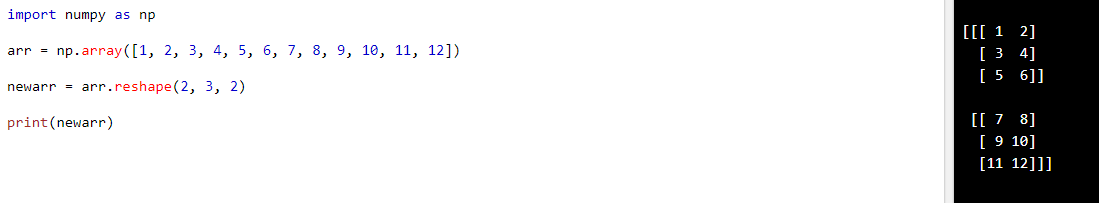

*Output Dict?*

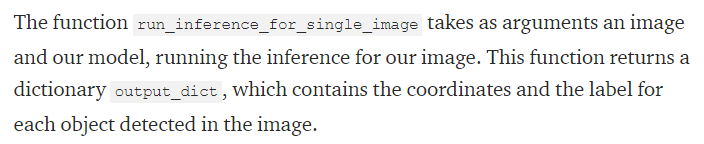

*Determining the size*

The average mannequin is around 6 feet tall or 1.8 meters (we round it to 2 meters for easier measurement)

According to our images, the mannequin that was shown on the glass box is having around 98 pixels or we can just round it to 100 pixels.

Since the safe distance is around 6 feet or 2 meters too, it means that as long as the objects are separeted by 100 pixels, they are still in the safe range.

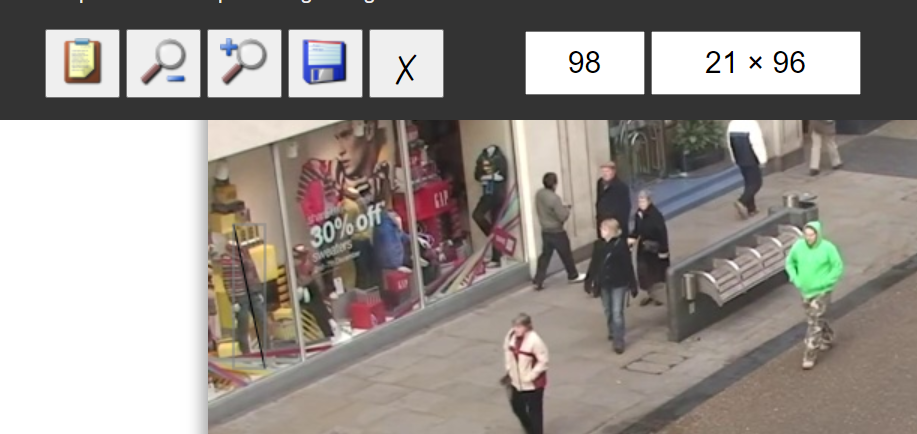

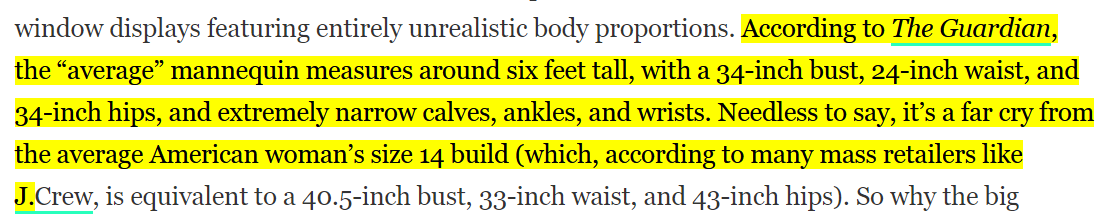

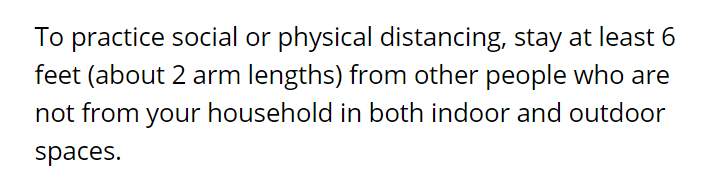

*Slope formula*

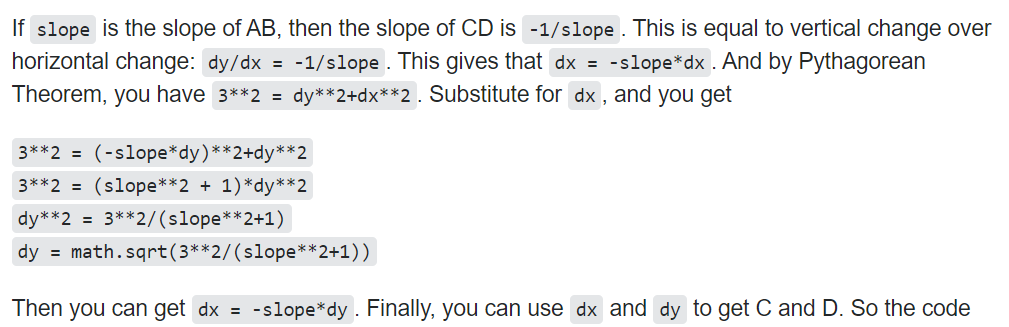

*Why we use (𝑛−1)⋅𝑛 to calculate the total number of connection?*


Let us say that we have 4 people in the picture. Each person will be connected with the other 3 people in this case. It means we will have 4 times 3 connection, where 4 comes from the number of person in the picture and 3 from the number of connection with the other (a person cannot be connected with himself)

### CODE

In [ ]:
IMAGE_OUTPUT_SIZE = (12, 8)
SAFE_DISTANCE = 100 #in pixels
VIOLATION_ARR = []

FROZEN_RFCN_GRAPH = "/content/drive/MyDrive/SocialDistancing/Models/exported/rfcn_exported/frozen_inference_graph.pb"
FROZEN_SSD_INCEPTION_GRAPH = "/content/drive/MyDrive/SocialDistancing/Models/exported/ssd_inception_exported/frozen_inference_graph.pb"
FROZEN_SSD_MOBILENET = "/content/drive/MyDrive/SocialDistancing/Models/exported/ssd_mobilenet_v1_coco_exported/frozen_inference_graph.pb"

#Please change the frozen_graph variable according to the model that you want to test
frozen_graph = FROZEN_RFCN_GRAPH

label_map = label_map_util.load_labelmap("/content/drive/MyDrive/SocialDistancing/label_map.pbtxt")

#================================Choose the image that we want to test manually=======================================
test_images = []
test_images.append("/content/drive/MyDrive/SocialDistancing/Extracted/Test/6120.jpg")
test_images.append("/content/drive/MyDrive/SocialDistancing/Extracted/Test/6217.jpg")
test_images.append("/content/drive/MyDrive/SocialDistancing/Extracted/Test/6257.jpg")
test_images.append("/content/drive/MyDrive/SocialDistancing/Extracted/Test/6436.jpg")
test_images.append("/content/drive/MyDrive/SocialDistancing/Extracted/Test/6800.jpg")

#=====================================================================================================================

#=================================Load the frozen graph===============================================================
detection_graph = tf.Graph()

with detection_graph.as_default():
  graph_def = tf.GraphDef()
  with tf.gfile.GFile(frozen_graph, 'rb') as fid:
    serialized_graph = fid.read()
    graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(graph_def, name='')

categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#=====================================================================================================================

#=========================================Change image to numpy array=================================================
def image_to_numpy_array(image):
  (real_width, real_height) = image.size
  return np.array(image.getdata()).reshape((real_height, real_width, 3)).astype(np.uint8)

#=====================================================================================================================

#========================================Calculation==================================================================
def calculate_coordinates(box, width, height):
  xmin = box[1] * width
  ymin = box[0] * height
  xmax = box[3] * width
  ymax = box[2] * height
  return [xmin, ymin, xmax - xmin, ymax - ymin]

def calculate_permutation(centroids):
  permutations = []
  for permutation in itertools.permutations(centroids, 2):
    if permutation[::-1] not in permutations:
      permutations.append(permutation)
  return permutations

#=====================================================================================================================

#========================================Look for the output_dict=====================================================
def run_inference(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      operations = tf.get_default_graph().get_operations()
      tensor_names = {output.name for operation in operations for output in operation.outputs}
      tensor_dict = {}
      for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
        tensor = key + ":0"
        if tensor in tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['num_detections'], [0])
        num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        
        detection_boxes = tf.slice(detection_boxes, [0,0], [num_detection, -1])
        
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [num_detection, -1, -1])
        detection_masks = util_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks = tf.cast(tf.greater(detection_masks, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(detection_masks, 0)
      
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}) #The image is from parameter
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  
  return output_dict

#=====================================================================================================================
#Determine how many times we should loop
limit = 0;

#The values that we count manually
real_violation = [10, 10, 6, 11, 7]

#(n-1)*n, where n is the number of person in the image
all_connection = [462, 380, 272, 342, 306]

#The pictures that we take are 6120, 6217, 6257, 6436, 6800
frames = [6120, 6217, 6257, 6436, 6800]

#Iterate each image that we have chosen before and plot the
#person detection along with the distance calculation
for image in test_images:
  violation = 0
  negative_count = 0
  image = Image.open(image)
  width, height = image.size

  '''---------- Bird's eye view [Partially done] ---------------------
  corners = np.array([[0, 445], [421, 540], [728, 0], [915, 0]], dtype=np.float32)

  #Inverse Perspective Mapping (IPM) --> Remove perspective effect by remapping the image, resulting a top-down view.
  ipm_params = np.array([[360,height],[540,height],[360,0],[540,0]], dtype=np.float32)
  ipm_matrix = cv2.getPerspectiveTransform(corners, ipm_params)
  '''

  image_np = image_to_numpy_array(image)

  #Turn this on to get the bird's eye view
  #image_np = cv2.warpPerspective(image_np, ipm_matrix, (width, height))

  output_dict = run_inference(image_np, detection_graph)

  centroids = []
  coordinates = []
  for box in output_dict['detection_boxes']:
    coordinate = calculate_coordinates(box, width, height)

    #[xmin, ymin, xmax - xmin, ymax - ymin]
    centroid = (coordinate[0] + (coordinate[2]/2), coordinate[1] + (coordinate[3]/2))

    '''------- To find the ground of the box ---------------------
    #centroid = list(centroid)
    #centroid[1] = centroid[1] + ((coordinate[3] - coordinate[1])/2)
    #centroid = tuple(centroid)
    '''

    centroids.append(centroid)
    coordinates.append(coordinate)

  permutations = calculate_permutation(centroids)

  # ------------------ Plot the person detection --------------------------------
  fig, axis = plt.subplots(figsize = (12, 8), dpi = 90)
  axis.imshow(image_np, interpolation='nearest')
  axis.text(20, height-70, "Real number of violations: {}".format(real_violation[limit]))

  for coordinate, centroid in zip(coordinates, centroids):
    plt.axis('off')
    axis.add_patch(matplotlib.patches.Rectangle((coordinate[0], coordinate[1]), coordinate[2], coordinate[3], linewidth=1, edgecolor='yellow', facecolor='none', zorder=10))
    axis.add_patch(matplotlib.patches.Circle((centroid[0], centroid[1]), 3, color='yellow', zorder=20))
  #------------------------------------------------------------------------------

  #----------------------- Distance Module --------------------------------------
  for permutation in permutations:
    x1 = permutation[0][0]
    x2 = permutation[1][0]
    y1 = permutation[0][1]
    y2 = permutation[1][1]

    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    average_distance = distance/SAFE_DISTANCE
    middle = ((x1 + x2)/2, (y1 + y2)/2)
    slope = (y2-y1)/(x2-x1)
    dy = math.sqrt(3**2 / (slope**2 + 1))
    dx = -slope * dy

    if random.randint(1, 10) % 2 == 0:
      dx = middle[0] - dx*10
      dy = middle[1] - dy*10
    else:
      dx = middle[0] + dx*10
      dy = middle[1] + dy*10

    if average_distance < 2:
      violation = violation + 1
      axis.annotate((round(average_distance, 2)), xy=middle, color='white', xytext=(dx, dy), fontsize=10, bbox=dict(facecolor='red', edgecolor='white', boxstyle='round', pad=0.2), zorder=30)
      axis.plot((x1, x2), (y1, y2), linewidth=2, color='red', zorder=15)
    else:
      negative_count = negative_count + 1
  #------------------------------------------------------------------------------

  '''--------------------------- Performance Measurement --------------------------
  Cheat sheet:
  FN --> Detected as no violation where violation exist
  TP --> Detected as violation and violation exists
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  '''
  axis.text(20, height-55, "Number of violation detected: {}".format(violation))
   
  FN = negative_count - (all_connection[limit] - real_violation[limit])

  Precision = real_violation[limit] / violation
  Recall = real_violation[limit] / (real_violation[limit] + FN)
  F1 = 2 * ((Precision * Recall)/(Precision + Recall))

  axis.text(20, height-40, "Precision: {}".format(Precision))
  axis.text(20, height-25, "Recall: {}".format(Recall))
  axis.text(20, height-10, "F1 Score: {}".format(F1))

  VIOLATION_ARR.append([frames[limit], violation])
  limit += 1


# Image Result


The summary of the predictions that we have made (Qualitative Analysis)

## Normal View
**SSD_Inception**

![](https://drive.google.com/uc?export=view&id=1hM7q13GejMnZMpe14QUQHr84ipd-GcWZ)




**RFCN**

![](https://drive.google.com/uc?export=view&id=1C6X0iKO-JKDeV-ucy0U_u4Sr0fg-5IZ5)



**SDD_Mobilenet_V1_Coco**

![](https://drive.google.com/uc?export=view&id=1iyTJ-dHD77CiWlZkbHn1gM0vKuHpJtrZ)


## BUG ?

**Failed to find the ground point**

Is it because we have to use the bird eye view?

![](https://drive.google.com/uc?export=view&id=1Cmvga0V0xvxVLz3ZsqWNg7MIv8hbjd0r)


First experiment with bird eye's view
![](https://drive.google.com/uc?export=view&id=1B3buftPta_F_3xmE4MaYUcZJ2ZvxKCA7)


# Tensorboard


Please change the path according to the model that you want to plot

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = '/content/drive/MyDrive/SocialDistancing/Models/trained/ssd_inception_trained/'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ded4fcf63d7b.ngrok.io


# Move to Anaconda

This should be the end of the things that we need to do in Google Colaboratory. You can follow the further instruction from our GitHub repository in order to run GUI and upload the photo or video that you have chosen.

Thank you!

GitHub Repository: https://github.com/Sasan-Tech/Automated-Social-Distance-Monitoring-System 